In [ ]:
import sys
print(sys.executable)

import torch
torch.set_grad_enabled(False)
print('Torch version:', torch.__version__)

import os
import numpy as np
from pathlib import Path
from bokeh.io import output_notebook
from datasets import load_dataset


from model_diffing.models.crosscoder import AcausalCrosscoder

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

base_dir = Path('../../checkpoints/')

/home/anna/Documents/MATS/crosscoders-feature-interactions/.venv/bin/python
Torch version: 2.6.0+cu124
cuda


In [2]:
checkpoints = {
    'JU05': ('act_newdata_JU05', 49999),
    'JU1': ('act_newdata_JU1', 49999),
    'JU2': ('act_newdata_JU2', 49999),
    'JU4': ('act_newdata_JU4', 49999),
    'JUL3': ('post3_lambS2', 49999),
    'JUL13': ('post13_lambS2', 49999),
}

In [3]:
def load_crosscoder(checkpoint_folder, step):
    cc = AcausalCrosscoder.load(base_dir / checkpoint_folder / f"epoch_0_step_{step}")
    cc.to(DEVICE)
    return cc

# load crosscoders
crosscoders = {
    cc: load_crosscoder(checkpoints[cc][0], checkpoints[cc][1])
    for cc in checkpoints
}

# load decoder features
features = {
    cc: crosscoder.W_dec_HXD.reshape(crosscoder.W_dec_HXD.shape[0], -1)
    for cc, crosscoder in crosscoders.items()
}

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformer_lens import HookedTransformer

llms = ['deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', 'Qwen/Qwen2.5-Math-1.5B']
base_llm = 'Qwen/Qwen2.5-1.5B'

loaded_llms = []
for llm in llms:
    model = AutoModelForCausalLM.from_pretrained(llm)
    hooked_model = HookedTransformer.from_pretrained(
            'Qwen/Qwen2.5-1.5B',
            hf_model=model,
            #revision=llm.revision,
            cache_dir=None,
        ).to(DEVICE)
    loaded_llms.append(hooked_model)

tokenizer = AutoTokenizer.from_pretrained('deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', padding_side='left')


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
2025-02-28 08:59:42 - WARNING - You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model Qwen/Qwen2.5-1.5B into HookedTransformer
Moving model to device:  cuda


2025-02-28 08:59:47 - WARNING - You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model Qwen/Qwen2.5-1.5B into HookedTransformer
Moving model to device:  cuda


In [5]:
#dataset = load_dataset("AI-MO/NuminaMath-TIR", split='test')
dataset = load_dataset("annasoli/r1qw_numinamath", split='test')
#

In [6]:
from einops import rearrange
from itertools import islice
import torch

def get_activations(input_str, model1, model2, crosscoder, tokenizer, layer=27):
    """
    Get feature activations from one or both models.
    
    Args:
        input_str: Input text to process
        model1: First model (can be None)
        model2: Second model (can be None)
        crosscoder: The trained crosscoder
        tokenizer: Tokenizer to use
        layer: Layer to extract activations from (default: 27)
    """
    tokens = torch.tensor(tokenizer.encode(input_str)[0:128])
    batch = tokens.unsqueeze(0)
    
    # Initialize with zeros for each model position
    activations_BSMLD = None
    
    # Extract activations for model1 (position 0)
    if model1 is not None:
        _, cache1 = model1.run_with_cache(batch, names_filter=[f"blocks.{layer}.hook_resid_post"])
        activations1_BSLD = torch.stack([cache1[name] for name in cache1.keys()], dim=2)
        # Add model dimension
        activations1_BSMLD = activations1_BSLD.unsqueeze(2)
        
        if activations_BSMLD is None:
            # Initialize with zeros for both model positions
            B, S, L, D = activations1_BSLD.shape
            activations_BSMLD = torch.zeros(B, S, 2, L, D, device=activations1_BSLD.device)
        
        # Place model1 activations at position 0
        activations_BSMLD[:, :, 0, :, :] = activations1_BSMLD[:, :, 0, :, :]
    
    # Extract activations for model2 (position 1)
    if model2 is not None:
        _, cache2 = model2.run_with_cache(batch, names_filter=[f"blocks.{layer}.hook_resid_post"])
        activations2_BSLD = torch.stack([cache2[name] for name in cache2.keys()], dim=2)
        # Add model dimension
        activations2_BSMLD = activations2_BSLD.unsqueeze(2)
        
        if activations_BSMLD is None:
            # Initialize with zeros for both model positions
            B, S, L, D = activations2_BSLD.shape
            activations_BSMLD = torch.zeros(B, S, 2, L, D, device=activations2_BSLD.device)
        
        # Place model2 activations at position 1
        activations_BSMLD[:, :, 1, :, :] = activations2_BSMLD[:, :, 0, :, :]
    
    # If we didn't initialize activations yet, both models were None
    if activations_BSMLD is None:
        raise ValueError("At least one model must be provided")
    
    # Apply normalization if needed (commented out in original code)
    # if cfg.norm_scaling_factors is not None:
    #     for m in range(activations_BSMLD.shape[2]):
    #         if (model1 is not None and m == 0) or (model2 is not None and m == 1):
    #             scaling_factors = torch.tensor(cfg.norm_scaling_factors[m], device=activations_BSMLD.device)
    #             activations_BSMLD[:, :, m, :, :] = activations_BSMLD[:, :, m, :, :] * scaling_factors
    
    # Rearrange for crosscoder encoding
    activations_SMLD = rearrange(activations_BSMLD, "b s m l d -> (b s) m l d")
    
    # Get feature activations
    feature_activations_SH = crosscoder._encode_BH(activations_SMLD)
    return feature_activations_SH

def get_top_activations(dataset, model1, model2, crosscoder, tokenizer, N=5, n_prompts=100, layer=27):
    """
    Get top N activations for each feature across the dataset.
    
    Args:
        dataset: Dataset to process
        model1: First model (can be None)
        model2: Second model (can be None)
        crosscoder: The trained crosscoder
        tokenizer: Tokenizer to use
        N: Number of top activations to keep per feature
        n_prompts: Number of prompts to process
        layer: Layer to extract activations from (default: 27)
    
    Returns:
        List of lists, where each inner list contains tuples of
        (activation_value, example, sequence_position) for that feature.
    """
    # Check that at least one model is provided
    if model1 is None and model2 is None:
        raise ValueError("At least one model must be provided")
    
    # Initialize list to store top activations for each feature
    top_activations = [[] for _ in range(crosscoder.hidden_dim)]
    
    # Process specified number of examples
    for example in islice(dataset, n_prompts):
        try:
            # Get the content from the example
            content = example["text"]
            activations = get_activations(content, model1, model2, crosscoder, tokenizer, layer=layer)
            
            for seq_pos in range(activations.shape[0]):
                # Get indices of non-zero activations
                active_features = torch.nonzero(activations[seq_pos]).squeeze(-1)
                
                # If no active features, continue to next position
                if active_features.numel() == 0:
                    continue
                
                # Handle case where there's only one non-zero activation
                if active_features.ndim == 0:
                    active_features = active_features.unsqueeze(0)
                
                # Update top activations for each active feature
                for feature_idx in active_features:
                    activation_val = activations[seq_pos, feature_idx].item()
                    top_activations[feature_idx].append((activation_val, example, seq_pos))
                    
                    # Sort and keep top N for this feature
                    top_activations[feature_idx].sort(key=lambda x: x[0], reverse=True)
                    if len(top_activations[feature_idx]) > N:
                        top_activations[feature_idx] = top_activations[feature_idx][:N]
        except Exception as e:
            print(f"Error processing example: {e}")
            continue
    
    return top_activations

In [7]:
from einops import rearrange
from itertools import islice
import torch

def get_mean_activations(dataset, model, tokenizer, num_samples=50):
    """
    Calculate mean activation vector for a model over a number of samples.
    
    Args:
        dataset: Dataset to sample from
        model: Model to get activations for
        tokenizer: Tokenizer to use
        num_samples: Number of samples to average over
    
    Returns:
        Mean activation tensor with shape [1, 1, L, D]
    """
    total_activations = None
    count = 0
    
    for example in islice(dataset, num_samples):
        try:
            content = example["text"]
            tokens = torch.tensor(tokenizer.encode(content)[0:128])
            batch = tokens.unsqueeze(0)
            
            _, cache = model.run_with_cache(batch, names_filter=["blocks.27.hook_resid_post"])
            activations_BSLD = torch.stack([cache[name] for name in cache.keys()], dim=2)
            
            if total_activations is None:
                total_activations = activations_BSLD
            else:
                # Pad shorter sequences if necessary
                max_seq_len = max(total_activations.shape[1], activations_BSLD.shape[1])
                
                if total_activations.shape[1] < max_seq_len:
                    pad_len = max_seq_len - total_activations.shape[1]
                    padding = torch.zeros(
                        total_activations.shape[0], pad_len, 
                        total_activations.shape[2], total_activations.shape[3],
                        device=total_activations.device
                    )
                    total_activations = torch.cat([total_activations, padding], dim=1)
                
                if activations_BSLD.shape[1] < max_seq_len:
                    pad_len = max_seq_len - activations_BSLD.shape[1]
                    padding = torch.zeros(
                        activations_BSLD.shape[0], pad_len, 
                        activations_BSLD.shape[2], activations_BSLD.shape[3],
                        device=activations_BSLD.device
                    )
                    activations_BSLD = torch.cat([activations_BSLD, padding], dim=1)
                
                total_activations = total_activations + activations_BSLD
            
            count += 1
        except Exception as e:
            print(f"Error processing example for mean calculation: {e}")
            continue
    
    if total_activations is None or count == 0:
        raise ValueError("Failed to calculate mean activations")
    
    # Compute mean
    mean_activations = total_activations / count
    
    return mean_activations

def get_activations_with_mean_baseline(input_str, model1, model2, model_id, crosscoder, tokenizer, mean_activations=None):
    """
    Get feature activations with mean baseline for the non-target model.
    
    Args:
        input_str: Input text to process
        model1: First model
        model2: Second model
        model_id: Which model to get activations for (0 for model1, 1 for model2)
        crosscoder: The trained crosscoder
        tokenizer: Tokenizer to use
        mean_activations: Pre-computed mean activations (optional)
    """
    tokens = torch.tensor(tokenizer.encode(input_str)[0:128])
    batch = tokens.unsqueeze(0)
    
    # Get activations for the specified model
    if model_id == 0:
        target_model = model1
        other_model = model2
    else:
        target_model = model2
        other_model = model1
    
    _, cache = target_model.run_with_cache(batch, names_filter=["blocks.3.hook_resid_post"])
    activations_BSLD = torch.stack([cache[name] for name in cache.keys()], dim=2)
    
    # Add model dimension
    activations_BSMLD = activations_BSLD.unsqueeze(2)
    
    # Initialize with shape based on current activations
    B, S, _, L, D = activations_BSMLD.shape
    all_activations_BSMLD = torch.zeros(B, S, 2, L, D, device=activations_BSMLD.device)
    
    # Place target model activations at the right position
    all_activations_BSMLD[:, :, model_id, :, :] = activations_BSMLD[:, :, 0, :, :]
    
    # Use mean activations for the other model position
    if mean_activations is not None:
        # Handle sequence length mismatch
        other_S = min(S, mean_activations.shape[1])
        all_activations_BSMLD[:, :other_S, 1-model_id, :, :] = mean_activations[:, :other_S, :, :]*0.5
    
    # Rearrange for crosscoder encoding
    activations_SMLD = rearrange(all_activations_BSMLD, "b s m l d -> (b s) m l d")
    
    # Get feature activations
    feature_activations_SH = crosscoder._encode_BH(activations_SMLD)
    return feature_activations_SH

def get_adjusted_top_activations(dataset, model1, model2, model_id, crosscoder, tokenizer, N=5, n_prompts=100):
    """
    Get top N activations for each feature across the dataset for the specified model,
    using mean activations from the other model as a baseline.
    
    Args:
        dataset: Dataset to process
        model1: First model
        model2: Second model
        model_id: Which model to get activations for (0 for model1, 1 for model2)
        crosscoder: The trained crosscoder
        tokenizer: Tokenizer to use
        N: Number of top activations to keep per feature
        n_prompts: Number of prompts to process
    
    Returns:
        List of lists, where each inner list contains tuples of
        (activation_value, example, sequence_position) for that feature.
    """
    # Check that both models are provided
    if model1 is None or model2 is None:
        raise ValueError("Both models must be provided")
    
    # Get the model to calculate mean activations for
    if model_id == 0:
        other_model = model2
    else:
        other_model = model1
    
    # Calculate mean activations for the other model
    print(f"Calculating mean activations for the baseline model...")
    mean_activations = get_mean_activations(dataset, other_model, tokenizer, num_samples=500)
    print(f"Mean activations shape: {mean_activations.shape}")
    
    # Initialize list to store top activations for each feature
    top_activations = [[] for _ in range(crosscoder.hidden_dim)]
    
    # Process specified number of examples
    processed_count = 0
    for example in islice(dataset, n_prompts):
        try:
            # Get the content from the example
            content = example["text"]
            activations = get_activations_with_mean_baseline(
                content, model1, model2, model_id, crosscoder, tokenizer, mean_activations
            )
            
            for seq_pos in range(activations.shape[0]):
                # Get indices of non-zero activations
                active_features = torch.nonzero(activations[seq_pos]).squeeze(-1)
                
                # If no active features, continue to next position
                if active_features.numel() == 0:
                    continue
                
                # Handle case where there's only one non-zero activation
                if active_features.ndim == 0:
                    active_features = active_features.unsqueeze(0)
                
                # Update top activations for each active feature
                for feature_idx in active_features:
                    activation_val = activations[seq_pos, feature_idx].item()
                    top_activations[feature_idx].append((activation_val, example, seq_pos))
                    
                    # Sort and keep top N for this feature
                    top_activations[feature_idx].sort(key=lambda x: x[0], reverse=True)
                    if len(top_activations[feature_idx]) > N:
                        top_activations[feature_idx] = top_activations[feature_idx][:N]
            
            processed_count += 1
            if processed_count % 100 == 0:
                print(f"Processed {processed_count} examples...")
        except Exception as e:
            print(f"Error processing example: {e}")
            continue
    
    return top_activations


'''adj_top_DS_activations5 = get_adjusted_top_activations(dataset, 
                                                   loaded_llms[0], 
                                                   loaded_llms[1], 0, 
                                                   crosscoders['JU2'], 
                                                   tokenizer, N=5, 
                                                   n_prompts=500
                                                   )

adj_top_QM_activations5 = get_adjusted_top_activations(dataset,
                                                    loaded_llms[0], 
                                                    loaded_llms[1], 1, 
                                                    crosscoders['JU2'], 
                                                    tokenizer, N=5, 
                                                    n_prompts=500
                                                    )'''

"adj_top_DS_activations5 = get_adjusted_top_activations(dataset, \n                                                   loaded_llms[0], \n                                                   loaded_llms[1], 0, \n                                                   crosscoders['JU2'], \n                                                   tokenizer, N=5, \n                                                   n_prompts=500\n                                                   )\n\nadj_top_QM_activations5 = get_adjusted_top_activations(dataset,\n                                                    loaded_llms[0], \n                                                    loaded_llms[1], 1, \n                                                    crosscoders['JU2'], \n                                                    tokenizer, N=5, \n                                                    n_prompts=500\n                                                    )"

In [8]:
top_DS_activationsL3 = get_top_activations(dataset, 
                                         loaded_llms[0], 
                                         None,
                                         crosscoders['JUL3'], 
                                         tokenizer,
                                         N=5, 
                                         n_prompts=500,
                                         layer=3
                                         )
top_QM_activationsL3 = get_top_activations(dataset, 
                                         None, 
                                         loaded_llms[1], 
                                         crosscoders['JUL3'], 
                                         tokenizer,
                                         N=5, 
                                         n_prompts=500,
                                         layer=3
                                         )

top_both_activationsL3 = get_top_activations(dataset,
                                            loaded_llms[0],
                                            loaded_llms[1],
                                            crosscoders['JUL3'],
                                            tokenizer,
                                            N=5,
                                            n_prompts=500,
                                            layer=3
                                            )

In [9]:
top_DS_activationsL13 = get_top_activations(dataset, 
                                         loaded_llms[0], 
                                         None,
                                         crosscoders['JUL13'], 
                                         tokenizer,
                                         N=5, 
                                         n_prompts=500,
                                            layer=13
                                         )
top_QM_activationsL13 = get_top_activations(dataset, 
                                         None, 
                                         loaded_llms[1], 
                                         crosscoders['JUL13'], 
                                         tokenizer,
                                         N=5, 
                                         n_prompts=500,
                                            layer=13
                                         )

top_both_activationsL13 = get_top_activations(dataset,
                                            loaded_llms[0], 
                                            loaded_llms[1], 
                                            crosscoders['JUL13'], 
                                            tokenizer,
                                            N=5, 
                                            n_prompts=500,
                                            layer=13
                                            )

In [10]:
top_DS_activations2 = get_top_activations(dataset, 
                                         loaded_llms[0], 
                                         None,
                                         crosscoders['JU2'], 
                                         tokenizer,
                                         N=5, 
                                         n_prompts=500
                                         )
top_QM_activations2 = get_top_activations(dataset, 
                                         None, 
                                         loaded_llms[1], 
                                         crosscoders['JU2'], 
                                         tokenizer,
                                         N=5, 
                                         n_prompts=500
                                         )

top_both_activations2 = get_top_activations(dataset,
                                            loaded_llms[0], 
                                            loaded_llms[1], 
                                            crosscoders['JU2'], 
                                            tokenizer,
                                            N=5, 
                                            n_prompts=500
                                            )

In [11]:
open_bracket = tokenizer.encode("[")[1]
close_bracket = tokenizer.encode("]")[1]

def format_token_in_example(top_activation):
    if top_activation is None:
        return "None"
    example = top_activation[1]["text"]
    token_index = top_activation[2]
    tokens = tokenizer.encode(example)
    tokens.insert(token_index, open_bracket)
    tokens.insert(token_index + 2, close_bracket)
    start = max(0, token_index - 10)
    return tokenizer.decode(tokens[start:token_index + 10])

def format_tokens_in_examples(top_activations):
    return [format_token_in_example(top_activation) for top_activation in top_activations]

In [13]:
# check overlap of activating features between two models
def get_overlap(top_activations1, top_activations2, top_activationsboth):
    n_dead = []
    n_active_1 = []
    n_active_2 = []
    n_active_12 = []
    n_active_both = []
    for i in range(len(top_activations1)):
        if (len(top_activations1[i]) == 0 and len(top_activations2[i]) == 0 
            and len(top_activationsboth[i]) == 0):
            n_dead.append(i)
        elif len(top_activations1[i]) != 0 and len(top_activations2[i]) != 0:
            n_active_12.append(i)
        elif len(top_activations1[i]) == 0:
            n_active_2.append(i)
        elif len(top_activations2[i]) == 0:
            n_active_1.append(i)
        else:
            n_active_both.append(i)

        
    return n_active_1, n_active_2, n_active_12, n_active_both, n_dead



'''n_active_1, n_active_2, n_active_both, n_dead = get_overlap(top_DS_activations, top_QM_activations)
print(f"Sparsity scaling 0.5")
print('----------------------')
print(f"Active in DS only: {len(n_active_1)}")
print(f"Active in QM only: {len(n_active_2)}")
print(f"Active in both: {len(n_active_both)}")
print(f"Dead: {len(n_dead)}")
print()

n_active_1, n_active_2, n_active_both, n_dead = get_overlap(top_DS_activations1, top_QM_activations1)
print(f"Sparsity scaling 1")
print('----------------------')
print(f"Active in DS only: {len(n_active_1)}")
print(f"Active in QM only: {len(n_active_2)}")
print(f"Active in both: {len(n_active_both)}")
print(f"Dead: {len(n_dead)}")
print()'''


n_active_1_L3, n_active_2_L3, n_active_12_L3, n_active_both_L3, n_dead_L3 = get_overlap(top_DS_activationsL3, top_QM_activationsL3, top_both_activationsL3)

print(f"Layer 3")
print('----------------------')
print(f"Active in DS only: {len(n_active_1_L3)}")
print(f"Active in QM only: {len(n_active_2_L3)}")
print(f"Active in DS and QM: {len(n_active_12_L3)}")
print(f"Active in both: {len(n_active_both_L3)}")
print(f'Total shared: {len(n_active_both_L3)+len(n_active_12_L3)}')
print(f"Dead: {len(n_dead_L3)}")
print()

n_active_1_L13, n_active_2_L13, n_active_12_L13, n_active_both_L13, n_dead_L13 = get_overlap(top_DS_activationsL13, top_QM_activationsL13, top_both_activationsL13)

print(f"Layer 13")
print('----------------------')
print(f"Active in DS only: {len(n_active_1_L13)}")
print(f"Active in QM only: {len(n_active_2_L13)}")
print(f"Active in DS and QM: {len(n_active_12_L13)}")
print(f"Active in both: {len(n_active_both_L13)}")
print(f'Total shared: {len(n_active_both_L13)+len(n_active_12_L13)}')
print(f"Dead: {len(n_dead_L13)}")
print()

'''overlap_n_active_both = [i for i in n_active_both2_L13 if i in n_active_both_L13_overlap]
overlap_active1_both = [i for i in n_active_1_L13 if i in n_active_both2_L13]

print(f"Overlap in both: {len(overlap_n_active_both)}")
print(f"Overlap in DS only: {len(overlap_active1_both)}")
'''

n_active_1_L27, n_active_2_L27, n_active_12_L27, n_active_both_L27, n_dead_L27 = get_overlap(top_DS_activations2, top_QM_activations2, top_both_activations2)

print(f"Layer 27")
print('----------------------')
print(f"Active in DS only: {len(n_active_1_L27)}")
print(f"Active in QM only: {len(n_active_2_L27)}")
print(f"Active in DS and QM: {len(n_active_12_L27)}")
print(f"Active in both: {len(n_active_both_L27)}")
print(f'Total shared: {len(n_active_both_L27)+len(n_active_12_L27)}')
print(f"Dead: {len(n_dead_L27)}")
print()


Layer 3
----------------------
Active in DS only: 136
Active in QM only: 291
Active in DS and QM: 5657
Active in both: 0
Total shared: 5657
Dead: 60

Layer 13
----------------------
Active in DS only: 146
Active in QM only: 985
Active in DS and QM: 4843
Active in both: 0
Total shared: 4843
Dead: 170

Layer 27
----------------------
Active in DS only: 550
Active in QM only: 1257
Active in DS and QM: 3947
Active in both: 0
Total shared: 3947
Dead: 390



In [15]:
i = 1
print(f"Feature {i}")
print("DS:")
formatted = format_tokens_in_examples(top_DS_activations2[i])
for f in formatted:
    print(f)
formatted = format_tokens_in_examples(top_QM_activations2[i])
print("QM:")
for f in formatted:
    print(f)
print()

Feature 1
DS:
 so I have this determinant to evaluate:

\[
[\]begin{vmatrix} 1
 This can be written as:
   \[
  [ \]frac{0.45}{
 of a multiset is given by:

\[
[\]frac{n!}{n_1
<｜begin▁of▁sentence｜>Evaluate the determinant:
\[
[\]begin{vmatrix} 1
 the definition of division. The equation is:

\[[ \]text{number} \div 
QM:
) that satisfy the system of equations:
\[
[\]left\{
\begin{array
 system of equations:
\[
\left\{
[\]begin{array}{l}
2
<｜begin▁of▁sentence｜>Evaluate the determinant:
\[
[\]begin{vmatrix} 1
 break it down into two separate sums:

\[
[\]sum_{k=1}^
} \) satisfying the following equations:
$$
[\]sum_{k=1}^{



In [57]:
for i in n_active_1_L27:
    print(f"Feature {i}")
    print("DS:")
    formatted = format_tokens_in_examples(top_DS_activations2[i])
    for f in formatted:
        print(f)
    formatted = format_tokens_in_examples(top_QM_activations2[i])
    print("QM:")
    for f in formatted:
        print(f)
    print()

Feature 50
DS:
 need to find what 'x' was.

Let[ me] break it down step by step.
's speed and Colin's speed. Let me try[ to] break this down step by step.


 me Bruce's speed and Colin's speed. Let[ me] try to break this down step by
 through the midpoint of segment DE. Let me try[ to] break it down step by step.


 have 59 spots. 

Alright, let['s] break this down. First, let
QM:

Feature 58
DS:
 m is greater than n, compare -2m[ +] 1 and -2n +
 -2m + 1 and -2n[ +] 1, and explain why.
 I have this quadratic function: y = (m[ +] 1)x^{m² -
 x - 2)(x - \ln x[ -] 1)} \). Hmm,
 x - 2)(x - \ln x[ -] 1) \geq 
QM:

Feature 86
DS:
2 + 1}$. <think>
Alright[,] so I've got these two math
sup>-2</sup> <think>
Alright[,] so I have this math problem to
 \sqrt{3}$. <think>
Alright[,] so I've got this function here
 does the first group work? <think>
Alright[,] so I have this problem here about
2021\). <think>
Alright[,] so I have this polynomial to factor
QM:

Feature 96
DS:
[<｜begin▁of▁sentence｜>]
C

In [17]:
for i in n_active_2_L27:
    print(f"Feature {i}")
    print("DS:")
    formatted = format_tokens_in_examples(top_DS_activations2[i])
    for f in formatted:
        print(f)
    formatted = format_tokens_in_examples(top_QM_activations2[i])
    print("QM:")
    for f in formatted:
        print(f)
    print()

Feature 0
DS:
QM:
 of $n$ in the counterexample can be[ (] ).

A: $-2$


$ in this case is $x^{2}$[.

]Using the formula of total probability:


n-1}^{m-1}}$.[**
]```python
import math

#

Feature 20
DS:
QM:
, √20 is approximately 4.[4]72.

Since 4.
<｜begin▁of▁sentence｜>Compute \(0.4[5] \div 0.00
<｜begin▁of▁sentence｜>Compute \(0.4[5] \div 0.00
 4.5 squared gives 20.[2]5, which is slightly more than
<｜begin▁of▁sentence｜>Compute \(0.[4]5 \div 0.0

Feature 23
DS:
QM:
1+3|+\sqrt{12}[$.]  
(2) Below is Xia
3 \leq s \leq 5[$.] <think>
Okay, so I
 the graph opens downwards, then $m=$____[.] <think>
Alright, so I
4-x^{2}}}{\ln x}[$.] <think>
Okay, so I
_{n-1}^{m-1}}[$.]**
```python
import math



Feature 25
DS:
QM:

Feature 31
DS:
QM:
 operation.

Let's calculate it using Python.
```[python]
# Calculate the remainder when 

Feature 33
DS:
QM:

Feature 35
DS:
QM:
 points that are not connected to each other formed from[ line] segments? (We assume that at
<｜begin▁of▁sentence｜>[Draw] the tangent 

In [18]:
for i in n_active_12_L27:
    print(f"Feature {i}")
    print("DS:")
    formatted = format_tokens_in_examples(top_DS_activations2[i])
    for f in formatted:
        print(f)
    formatted = format_tokens_in_examples(top_QM_activations2[i])
    print("QM:")
    for f in formatted:
        print(f)
    print()

Feature 1
DS:
 so I have this determinant to evaluate:

\[
[\]begin{vmatrix} 1
 This can be written as:
   \[
  [ \]frac{0.45}{
 of a multiset is given by:

\[
[\]frac{n!}{n_1
<｜begin▁of▁sentence｜>Evaluate the determinant:
\[
[\]begin{vmatrix} 1
 the definition of division. The equation is:

\[[ \]text{number} \div 
QM:
) that satisfy the system of equations:
\[
[\]left\{
\begin{array
 system of equations:
\[
\left\{
[\]begin{array}{l}
2
<｜begin▁of▁sentence｜>Evaluate the determinant:
\[
[\]begin{vmatrix} 1
 break it down into two separate sums:

\[
[\]sum_{k=1}^
} \) satisfying the following equations:
$$
[\]sum_{k=1}^{

Feature 2
DS:
 So, each path is a straight line, right[?] Maybe like the x, y,
1_2\). Hmm, binary, right[?] I remember that binary is base 
 10. Hmm, harmonic mean, right[?] I remember that it's different from
 What is the percentage of the stock he invested in[?] Hmm, okay. Let me try
 are not connected to each other formed from line segments[?] We assume that at the 

In [24]:
import torch as t
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def plot_decoder_cosine_similarities(crosscoder):
    """
    Plot the distribution of cosine similarities between decoder vectors for ALL features.
    
    Args:
        crosscoder: A trained AcausalCrosscoder instance
    """
    # Get the decoder weights
    W_dec_HXD = crosscoder.W_dec_HXD.detach().cpu()
    
    # Check if we have exactly 2 models (for model diffing)
    assert W_dec_HXD.shape[1] == 2, "This function expects exactly 2 models for comparison"
    
    hidden_dim = W_dec_HXD.shape[0]
    
    # Calculate cosine similarity for all features
    cosine_similarities = []
    
    for h in range(hidden_dim):
        vec_A = W_dec_HXD[h, 0, :, :].flatten()
        vec_B = W_dec_HXD[h, 1, :, :].flatten()
        
        # Only compute similarity if both vectors have non-zero norm
        if t.norm(vec_A) > 1e-6 and t.norm(vec_B) > 1e-6:
            # Calculate cosine similarity
            similarity = F.cosine_similarity(vec_A.unsqueeze(0), vec_B.unsqueeze(0)).item()
            cosine_similarities.append(similarity)
        else:
            # If either vector is essentially zero, we can't meaningfully compute similarity
            # This typically happens for model-exclusive features
            pass
    
    # Convert to numpy array
    cosine_similarities = np.array(cosine_similarities)
    
    # Create the histogram plot with log scale
    plt.figure(figsize=(8, 6))
    
    # Define bins from -1 to 1
    bins = np.linspace(-1, 1, 21)  # 20 bins from -1 to 1
    
    # Plot histogram with log scale for y-axis
    plt.hist(cosine_similarities, bins=bins, alpha=0.7, color='#e09c83')
    plt.yscale('log')
    
    # Add grid and labels
    plt.grid(alpha=0.3, which='both')
    plt.xlabel("Cosine similarity of decoder vectors")
    plt.ylabel("Density")
    plt.xlim(-1.1, 1.1)
    plt.ylim(1, 10000)  # Adjust based on your data
    
    # Print some statistics
    print(f"Number of features with valid cosine similarity: {len(cosine_similarities)}")
    print(f"Average cosine similarity: {np.mean(cosine_similarities):.4f}")
    print(f"Proportion with similarity > 0.5: {np.mean(cosine_similarities > 0.5):.4f}")
    
    plt.tight_layout()
    plt.savefig("decoder_cosine_similarities_all_features.png", dpi=300)
    plt.show()

import torch as t
import matplotlib.pyplot as plt
import numpy as np
from model_diffing.utils import l2_norm

def plot_relative_decoder_norms(crosscoder):
    """
    Plot the distribution of relative decoder norms between two models.
    
    Args:
        crosscoder: A trained AcausalCrosscoder instance
    """
    # Get the decoder weights
    W_dec_HXD = crosscoder.W_dec_HXD.detach().cpu()
    
    # Check if we have exactly 2 models (for model diffing)
    assert W_dec_HXD.shape[1] == 2, "This function expects exactly 2 models for comparison"
    
    hidden_dim = W_dec_HXD.shape[0]
    n_models, n_hookpoints, d_model = W_dec_HXD.shape[1], W_dec_HXD.shape[2], W_dec_HXD.shape[3]
    
    # Compute l2 norms for each feature and model
    # For each feature (h), compute its norm across all hookpoints and d_model dimensions
    model_A_norms = t.zeros(hidden_dim)
    model_B_norms = t.zeros(hidden_dim)
    
    for h in range(hidden_dim):
        # Calculate l2 norm for model A (index 0)
        model_A_norms[h] = l2_norm(W_dec_HXD[h, 0, :, :])
        
        # Calculate l2 norm for model B (index 1)
        model_B_norms[h] = l2_norm(W_dec_HXD[h, 1, :, :])
    
    # Compute relative norms
    total_norms = model_A_norms + model_B_norms
    relative_norms = t.zeros_like(model_B_norms)
    
    # Avoid division by zero
    nonzero_mask = total_norms > 0
    relative_norms[nonzero_mask] = model_B_norms[nonzero_mask] / total_norms[nonzero_mask]
    
    # Convert to numpy for plotting
    relative_norms_np = relative_norms.numpy()
    
    # Create the histogram plot
    plt.figure(figsize=(10, 6))
    
    # Define bins and count features in each bin
    bin_edges = np.linspace(0, 1, 21)  # 20 bins from 0 to 1
    hist, _ = np.histogram(relative_norms_np, bins=bin_edges)
    
    # Plot the histogram
    plt.bar(bin_edges[:-1], hist, width=0.05, alpha=0.7, color='#e09c83')
    
    # Add vertical lines at 0.5
    plt.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
    
    # Add labels
    plt.text(0.1, plt.ylim()[1]*0.9, "DS-specific", fontsize=12)
    plt.text(0.8, plt.ylim()[1]*0.9, "QM-specific", fontsize=12)
    
    # Count specific features
    A_specific = (relative_norms_np < 0.05).sum()
    # get id of features that are specific to model A
    A_specific_ids = np.where(relative_norms_np < 0.05)
    print(A_specific_ids)
    B_specific = (relative_norms_np > 0.95).sum()
    shared = ((relative_norms_np >= 0.05) & (relative_norms_np <= 0.95)).sum()
    
    print(f"Model A specific features: {A_specific}")
    print(f"Model B specific features: {B_specific}")
    print(f"Shared features: {shared}")
    # y axes as log scale
    #plt.yscale('log')
    

    
    plt.xlabel("Relative decoder norm")
    plt.ylabel("Number of features")
    #plt.title("Toy model: Number of features by relative decoder norm")
    plt.tight_layout()
    plt.savefig("relative_decoder_norms.png", dpi=300)
    plt.show()

Number of features with valid cosine similarity: 6080
Average cosine similarity: 0.8160
Proportion with similarity > 0.5: 0.9520


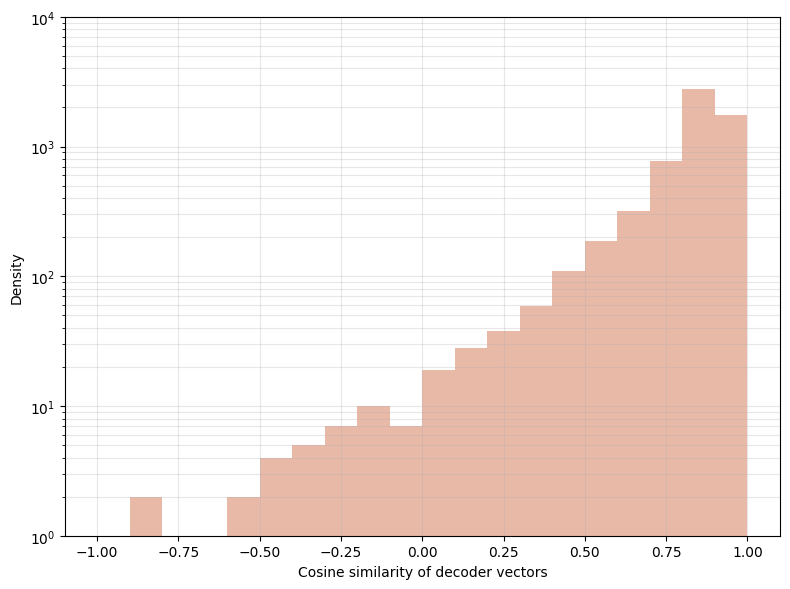

In [53]:
plot_decoder_cosine_similarities(crosscoders['JU2'])

(array([923]),)
Model A specific features: 1
Model B specific features: 0
Shared features: 6143


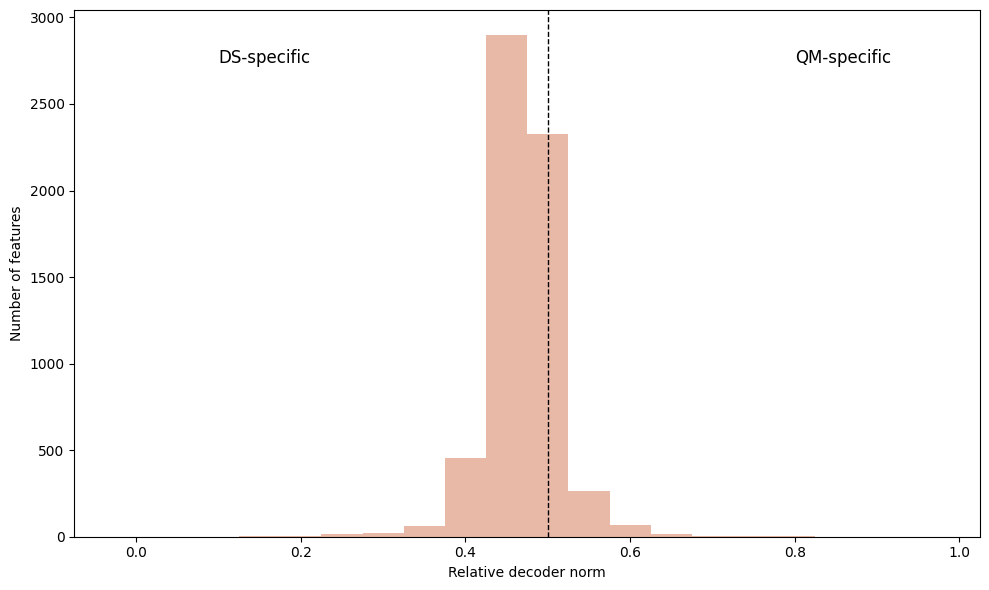

In [51]:
plot_relative_decoder_norms(crosscoders['JU2'])

In [51]:
import torch as t
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def plot_decoder_cosine_similarities(crosscoder, ds_features=None, qm_features=None, both_features=None):
    """
    Plot the distribution of cosine similarities between decoder vectors for ALL features.
    
    Args:
        crosscoder: A trained AcausalCrosscoder instance
        ds_features: Optional list of DS-specific feature indices
        qm_features: Optional list of QM-specific feature indices
        both_features: Optional list of shared feature indices
    """
    # Get the decoder weights
    W_dec_HXD = crosscoder.W_dec_HXD.detach().cpu()
    
    # Check if we have exactly 2 models (for model diffing)
    assert W_dec_HXD.shape[1] == 2, "This function expects exactly 2 models for comparison"
    
    hidden_dim = W_dec_HXD.shape[0]
    
    # Calculate cosine similarity for all features
    cosine_similarities = []
    feature_indices = []
    
    for h in range(hidden_dim):
        vec_A = W_dec_HXD[h, 0, :, :].flatten()
        vec_B = W_dec_HXD[h, 1, :, :].flatten()
        
        # Only compute similarity if both vectors have non-zero norm
        if t.norm(vec_A) > 1e-6 and t.norm(vec_B) > 1e-6:
            # Calculate cosine similarity
            similarity = F.cosine_similarity(vec_A.unsqueeze(0), vec_B.unsqueeze(0)).item()
            cosine_similarities.append(similarity)
            feature_indices.append(h)
        else:
            # If either vector is essentially zero, we can't meaningfully compute similarity
            # This typically happens for model-exclusive features
            pass
    
    # Convert to numpy array
    cosine_similarities = np.array(cosine_similarities)
    feature_indices = np.array(feature_indices)
    
    # Create the histogram plot with log scale
    plt.figure(figsize=(8, 6))
    
    # Define bins from -1 to 1
    bins = np.linspace(-1, 1, 21)  # 20 bins from -1 to 1
    
    # Plot overlaid histograms if feature lists are provided
    if ds_features is not None or qm_features is not None or both_features is not None:
        # Convert feature lists to numpy arrays if they're not already
        ds_features = np.array(ds_features) if ds_features is not None else np.array([])
        qm_features = np.array(qm_features) if qm_features is not None else np.array([])
        both_features = np.array(both_features) if both_features is not None else np.array([])
        
        # Create masks for each feature type
        ds_mask = np.isin(feature_indices, ds_features)
        qm_mask = np.isin(feature_indices, qm_features)
        both_mask = np.isin(feature_indices, both_features)
        
        # Plot separate histograms for each feature type
        if len(ds_features) > 0:
            plt.hist(cosine_similarities[ds_mask], bins=bins, alpha=0.6, color='#e09c83', label='DS-specific')
        
        if len(qm_features) > 0:
            plt.hist(cosine_similarities[qm_mask], bins=bins, alpha=0.6, color='#83a4e0', label='QM-specific')
        
        if len(both_features) > 0:
            plt.hist(cosine_similarities[both_mask], bins=bins, alpha=0.6, color='#83e09c', label='Shared')
        
        # Plot remaining features if any
        remaining_mask = ~(ds_mask | qm_mask | both_mask)
        if np.any(remaining_mask):
            plt.hist(cosine_similarities[remaining_mask], bins=bins, alpha=0.4, color='#cccccc', label='Other')
        
        plt.legend()
    else:
        # Original plot for all features if no lists provided
        plt.hist(cosine_similarities, bins=bins, alpha=0.7, color='#e09c83')
    
    # Set y-axis to log scale
    plt.yscale('log')
    
    # Add grid and labels
    plt.grid(alpha=0.3, which='both')
    plt.xlabel("Cosine similarity of decoder vectors")
    plt.ylabel("Density")
    plt.xlim(-1.1, 1.1)
    plt.ylim(1, 10000)  # Adjust based on your data
    
    # Print some statistics
    print(f"Number of features with valid cosine similarity: {len(cosine_similarities)}")
    print(f"Average cosine similarity: {np.mean(cosine_similarities):.4f}")
    print(f"Proportion with similarity > 0.5: {np.mean(cosine_similarities > 0.5):.4f}")
    
    # Print statistics for each feature type if provided
    if ds_features is not None:
        ds_sims = cosine_similarities[ds_mask] if np.any(ds_mask) else []
        print(f"\nDS-specific features: {len(ds_sims)}")
        if len(ds_sims) > 0:
            print(f"  Average cosine similarity: {np.mean(ds_sims):.4f}")
    
    if qm_features is not None:
        qm_sims = cosine_similarities[qm_mask] if np.any(qm_mask) else []
        print(f"\nQM-specific features: {len(qm_sims)}")
        if len(qm_sims) > 0:
            print(f"  Average cosine similarity: {np.mean(qm_sims):.4f}")
    
    if both_features is not None:
        both_sims = cosine_similarities[both_mask] if np.any(both_mask) else []
        print(f"\nShared features: {len(both_sims)}")
        if len(both_sims) > 0:
            print(f"  Average cosine similarity: {np.mean(both_sims):.4f}")
    
    plt.tight_layout()
    plt.savefig("decoder_cosine_similarities_all_features.png", dpi=300)
    plt.show()

def plot_relative_decoder_norms(crosscoder, ds_features=None, qm_features=None, both_features=None):
    """
    Plot the distribution of relative decoder norms between two models.
    
    Args:
        crosscoder: A trained AcausalCrosscoder instance
        ds_features: Optional list of DS-specific feature indices
        qm_features: Optional list of QM-specific feature indices
        both_features: Optional list of shared feature indices
    """
    # Get the decoder weights
    W_dec_HXD = crosscoder.W_dec_HXD.detach().cpu()
    
    # Check if we have exactly 2 models (for model diffing)
    assert W_dec_HXD.shape[1] == 2, "This function expects exactly 2 models for comparison"
    
    hidden_dim = W_dec_HXD.shape[0]
    n_models, n_hookpoints, d_model = W_dec_HXD.shape[1], W_dec_HXD.shape[2], W_dec_HXD.shape[3]
    
    # Compute l2 norms for each feature and model
    # For each feature (h), compute its norm across all hookpoints and d_model dimensions
    model_A_norms = t.zeros(hidden_dim)
    model_B_norms = t.zeros(hidden_dim)
    
    for h in range(hidden_dim):
        # Calculate l2 norm for model A (index 0)
        model_A_norms[h] = l2_norm(W_dec_HXD[h, 0, :, :])
        
        # Calculate l2 norm for model B (index 1)
        model_B_norms[h] = l2_norm(W_dec_HXD[h, 1, :, :])
    
    # Compute relative norms
    total_norms = model_A_norms + model_B_norms
    relative_norms = t.zeros_like(model_B_norms)
    
    # Avoid division by zero
    nonzero_mask = total_norms > 0
    relative_norms[nonzero_mask] = model_B_norms[nonzero_mask] / total_norms[nonzero_mask]
    
    # Convert to numpy for plotting
    relative_norms_np = relative_norms.numpy()
    
    # Create the histogram plot
    plt.figure(figsize=(10, 6))
    
    # Define bins and count features in each bin
    bin_edges = np.linspace(0, 1, 21)  # 20 bins from 0 to 1
    
    # If feature lists are provided, plot overlaid histograms
    if ds_features is not None or qm_features is not None or both_features is not None:
        # Convert feature lists to numpy arrays if they're not already
        ds_features = np.array(ds_features) if ds_features is not None else np.array([])
        qm_features = np.array(qm_features) if qm_features is not None else np.array([])
        both_features = np.array(both_features) if both_features is not None else np.array([])
        
        # Plot histograms for each feature type
        if len(ds_features) > 0:
            ds_norms = relative_norms_np[ds_features]
            hist_ds, _ = np.histogram(ds_norms, bins=bin_edges)
            plt.bar(bin_edges[:-1], hist_ds, width=0.05, alpha=0.6, color='#e09c83', label='DS-specific')
        
        if len(qm_features) > 0:
            qm_norms = relative_norms_np[qm_features]
            hist_qm, _ = np.histogram(qm_norms, bins=bin_edges)
            plt.bar(bin_edges[:-1] + 0.0166, hist_qm, width=0.05, alpha=0.6, color='#83a4e0', label='QM-specific')
        
        if len(both_features) > 0:
            both_norms = relative_norms_np[both_features]
            hist_both, _ = np.histogram(both_norms, bins=bin_edges)
            plt.bar(bin_edges[:-1] + 0.0333, hist_both, width=0.05, alpha=0.6, color='#83e09c', label='Shared')
        
        # Plot remaining features if any
        all_specified = np.concatenate([ds_features, qm_features, both_features])
        remaining = np.setdiff1d(np.arange(hidden_dim), all_specified)
        if len(remaining) > 0:
            other_norms = relative_norms_np[remaining]
            hist_other, _ = np.histogram(other_norms, bins=bin_edges)
            plt.bar(bin_edges[:-1] - 0.0166, hist_other, width=0.05, alpha=0.4, color='#cccccc', label='Other')
        
        plt.legend()
    else:
        # Original plot for all features
        hist, _ = np.histogram(relative_norms_np, bins=bin_edges)
        plt.bar(bin_edges[:-1], hist, width=0.05, alpha=0.6, color='#e09c83')
    
    # Add vertical lines at 0.5
    plt.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
    
    # Add labels
    plt.text(0.1, plt.ylim()[1]*0.9, "DS-specific", fontsize=12)
    plt.text(0.8, plt.ylim()[1]*0.9, "QM-specific", fontsize=12)
    
    plt.xlabel("Relative decoder norm")
    plt.ylabel("Number of features")
    plt.tight_layout()
    plt.savefig("relative_decoder_norms.png", dpi=300)
    plt.show()

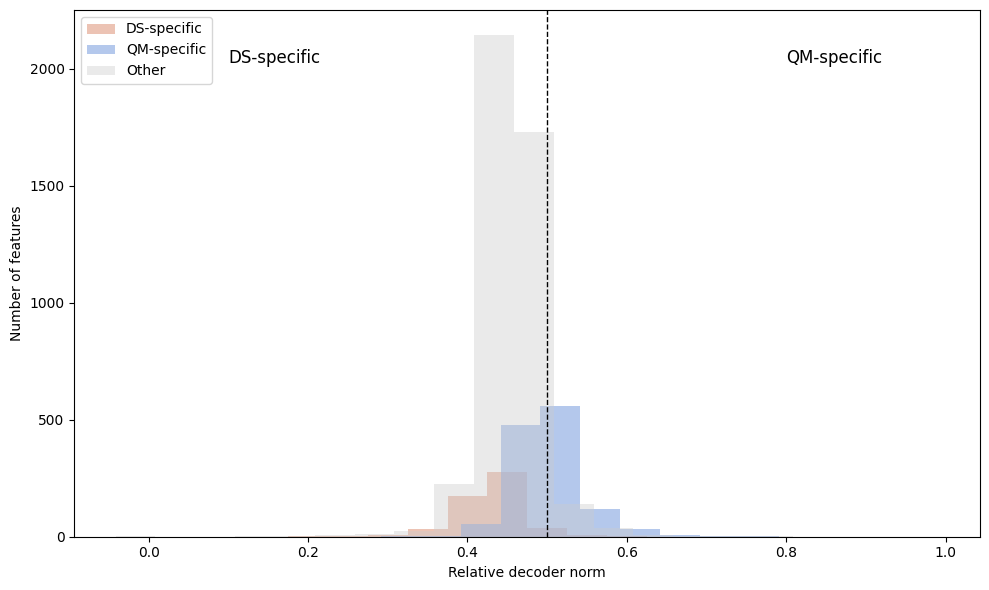

In [52]:
plot_relative_decoder_norms(crosscoders['JU2'], n_active_1_L27, n_active_2_L27)


In [54]:
def get_features_by_relative_norm_percentile(crosscoder):
    """
    Returns feature indices grouped by relative decoder norm percentiles:
    - bottom 10% (closest to model A)
    - middle 80%
    - top 10% (closest to model B)
    
    Args:
        crosscoder: A trained AcausalCrosscoder instance
        
    Returns:
        Tuple of (bottom_10_pct, middle_80_pct, top_10_pct) containing feature indices
    """
    # Get the decoder weights
    W_dec_HXD = crosscoder.W_dec_HXD.detach().cpu()
    
    # Check if we have exactly 2 models (for model diffing)
    assert W_dec_HXD.shape[1] == 2, "This function expects exactly 2 models for comparison"
    
    hidden_dim = W_dec_HXD.shape[0]
    
    # Compute l2 norms for each feature and model
    model_A_norms = t.zeros(hidden_dim)
    model_B_norms = t.zeros(hidden_dim)
    
    for h in range(hidden_dim):
        # Calculate l2 norm for model A (index 0)
        model_A_norms[h] = l2_norm(W_dec_HXD[h, 0, :, :])
        
        # Calculate l2 norm for model B (index 1)
        model_B_norms[h] = l2_norm(W_dec_HXD[h, 1, :, :])
    
    # Compute relative norms
    total_norms = model_A_norms + model_B_norms
    relative_norms = t.zeros_like(model_B_norms)
    
    # Avoid division by zero
    nonzero_mask = total_norms > 0
    relative_norms[nonzero_mask] = model_B_norms[nonzero_mask] / total_norms[nonzero_mask]
    
    # Convert to numpy for easier handling
    relative_norms_np = relative_norms.numpy()
    
    # Get indices sorted by relative norm
    sorted_indices = np.argsort(relative_norms_np)
    
    # Calculate cutoff points for percentiles
    n_features = len(sorted_indices)
    bottom_cutoff = int(n_features * 0.05)
    top_cutoff = int(n_features * 0.95)
    
    # Get the feature indices for each percentile group
    bottom_10_pct = sorted_indices[:bottom_cutoff]  # Model A specific (lowest relative norm)
    middle_80_pct = sorted_indices[bottom_cutoff:top_cutoff]  # Shared features
    top_10_pct = sorted_indices[top_cutoff:]  # Model B specific (highest relative norm)

    return bottom_10_pct, middle_80_pct, top_10_pct

In [59]:
bottom_5_pct, middle_90_pct, top_5_pct = get_features_by_relative_norm_percentile(crosscoders['JU2'])

# print activations from the top/bot
for i in bottom_5_pct:
    if len(top_both_activations2[i]) == 0:
        continue
    print(f"Feature {i}")
    formatted = format_tokens_in_examples(top_both_activations2[i])
    for f in formatted:
        print(f)
    print()

Feature 4901
 at today's matinee? To solve this problem[,] we need to determine the number of
 of problems Ryan composes? To solve this problem[,] we need to determine the number of
 To determine the size of each serving of orange juice[,] we need to follow these steps:


 book between the two branches. To solve this problem[,] we need to set up a system
 potatoes did the garden produce? To solve this problem[,] we need to set up equations based

Feature 6064
1$

D: $2bc$ and $[2]abc$ <think>
Okay,
1$

D: $2bc$ and $[2]abc$ To determine which sets of
 - 4)$. To expand the expression \[((]3t^3 + 2
e\). To rewrite the expression \(\left[(]16d + 17
[<｜begin▁of▁sentence｜>]
Compute the definite integral:

$$

Feature 3539
[<｜begin▁of▁sentence｜>]Emily is making bead necklaces for
[<｜begin▁of▁sentence｜>]
Compute the definite integral:

$$
[<｜begin▁of▁sentence｜>]
From point \(D\),
[<｜begin▁of▁sentence｜>]
Given the sequence $\left\
[<｜begin▁of▁sentence｜>]
Grandpa is twice as strong

Feature 149

In [48]:
# compare overlap between top 5% and top 5% by relative norm
overlap_top5_2 = [i for i in top_5_pct if i in n_active_2_L27]
overlap_bot5_1 = [i for i in bottom_5_pct if i in n_active_1_L27]
print(f"Overlap in top 5% (QM): {len(overlap_top5_2)} (Out of {len(top_5_pct)} and {len(n_active_2_L27)})")
print(f"Overlap in bottom 5% (DF): {len(overlap_bot5_1)} (Out of {len(bottom_5_pct)} and {len(n_active_1_L27)})")


Overlap in top 5% (QM): 139 (Out of 308 and 1257)
Overlap in bottom 5% (DF): 139 (Out of 307 and 550)


In [56]:
# look at overlap features
for i in overlap_bot5_1:
    print(f"Feature {i}")
    formatted = format_tokens_in_examples(top_both_activations2[i])
    for f in formatted:
        print(f)
    print()

Feature 6064
1$

D: $2bc$ and $[2]abc$ <think>
Okay,
1$

D: $2bc$ and $[2]abc$ To determine which sets of
 - 4)$. To expand the expression \[((]3t^3 + 2
e\). To rewrite the expression \(\left[(]16d + 17
[<｜begin▁of▁sentence｜>]
Compute the definite integral:

$$

Feature 3539
[<｜begin▁of▁sentence｜>]Emily is making bead necklaces for
[<｜begin▁of▁sentence｜>]
Compute the definite integral:

$$
[<｜begin▁of▁sentence｜>]
From point \(D\),
[<｜begin▁of▁sentence｜>]
Given the sequence $\left\
[<｜begin▁of▁sentence｜>]
Grandpa is twice as strong

Feature 2935

Feature 435
 that.

Let me start by listing out the letters[ in] MOON. M, O,
 among boxes, and he wants each box to have[ the] same number of coins. The question
 2 points. Which of the following is NOT[ a] true statement about the list of 
8 children. The problem states there are a certain[ number] more children than adults. Let's
 number of letters. But in this case, the[ word] has repeating letters, so I think

Feature 242
\):
   \[
   (-2)^